In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [6]:
model_name = "mobilenetv2-035-128"

#NOTICE HOW WE ARE USING FEATURE VECTOR FOR THIS STEP AND NOT CLASSIFIER
model_handle_map = {
  "mobilenetv2-035-128": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/classification/2",
}

model_image_size_map = {
  "mobilenetv2-035-128": 128,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 128)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 4

Selected model: mobilenetv2-035-128 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/classification/2
Input size (128, 128)


In [8]:
images_path = '/content/drive/MyDrive/Colab Notebooks/Assets/archive/Images/Images/'

labels_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assets/archive/metadata.csv')
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('clean', 'dirty')
num_classes = len(class_names)

img_size = (128, 128, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


labels = []
images = []
for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(images_path + image[0], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))

    # labels will be in the form of a vector: [0, 1] or [1, 0]
    label = np.zeros(num_classes)
    label[image[1]] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')



labels dataframe: 
         filename  label
0    dirty_2.jpg      1
1   clean_36.jpg      0
2   clean_31.jpg      0
3   dirty_69.jpg      1
4  clean_113.jpg      0 


2 classes: ('clean', 'dirty')
image size: (128, 128, 3)

labels shape: (237, 2)
images shape: (237, 128, 128, 3)


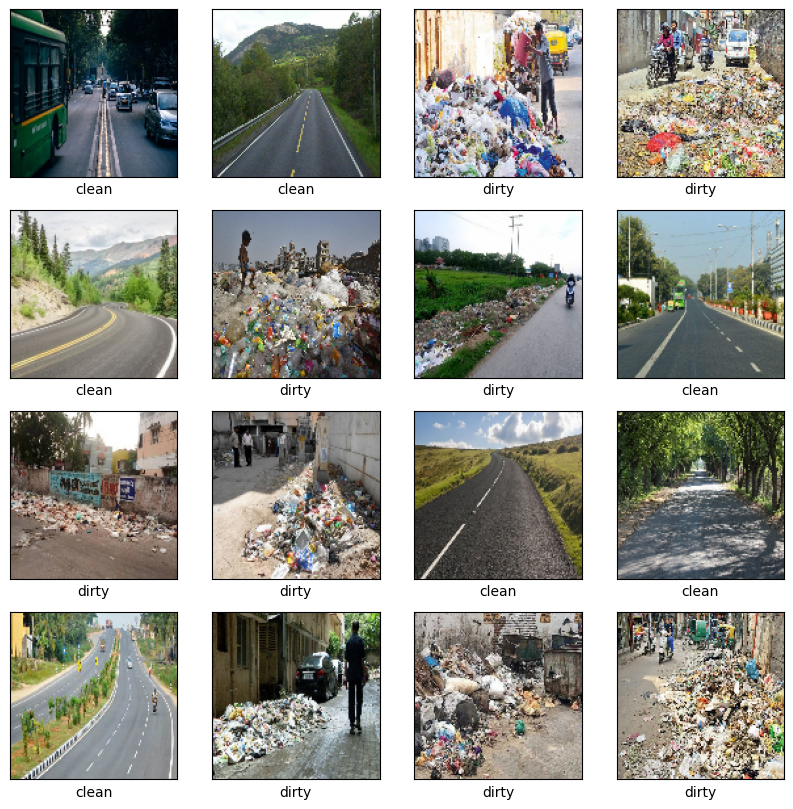

In [9]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))

        axs[x][y].imshow(images[i])

        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])

plt.show()

In [10]:
# DEFINE TRAIN/TEST SPLIT
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (213, 128, 128, 3)
train labels shape: (213, 2)

validation images shape: (24, 128, 128, 3)
validation labels shape: (24, 2)



In [11]:
# ImageDataGenerator for train images
train_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3,
                                                                         rotation_range=15,
                                                                         zoom_range=0.3,
                                                                         vertical_flip=True,
                                                                         horizontal_flip=True)
train_images_generator = train_images_generator.flow(X_train, y=y_train)

# ImageDataGenerator for validation images
validation_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True,
                                                                              horizontal_flip=True)
validation_images_generator = validation_images_generator.flow(X_val, y=y_val)

In [12]:
do_fine_tuning = False

print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 2)                 2004      
                                                                 
Total params: 3542269 (13.51 MB)
Trainable params: 2004 (7.83 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


In [13]:
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}')

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

train_size = X_train.shape[0]
valid_size = X_val.shape[0]
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_images_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_images_generator, callbacks=[checkpoint_callback])

Epoch 1/20
7/7 [==============================] - 17s 2s/step - loss: 0.7684 - accuracy: 0.6901 - val_loss: 0.8314 - val_accuracy: 0.6667
Epoch 2/20
7/7 [==============================] - 13s 2s/step - loss: 0.7193 - accuracy: 0.6854 - val_loss: 0.5515 - val_accuracy: 0.8333
Epoch 3/20
7/7 [==============================] - 15s 2s/step - loss: 0.7167 - accuracy: 0.7653 - val_loss: 0.3477 - val_accuracy: 0.9583
Epoch 4/20
7/7 [==============================] - 12s 2s/step - loss: 0.6610 - accuracy: 0.7793 - val_loss: 0.3967 - val_accuracy: 0.8750
Epoch 5/20
7/7 [==============================] - 13s 2s/step - loss: 0.6130 - accuracy: 0.7559 - val_loss: 0.4986 - val_accuracy: 0.7917
Epoch 6/20
7/7 [==============================] - 11s 2s/step - loss: 0.5556 - accuracy: 0.7887 - val_loss: 0.3792 - val_accuracy: 0.9167
Epoch 7/20
7/7 [==============================] - 12s 2s/step - loss: 0.6012 - accuracy: 0.7606 - val_loss: 0.5450 - val_accuracy: 0.8333
Epoch 8/20
7/7 [==================

In [15]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(accuracy))

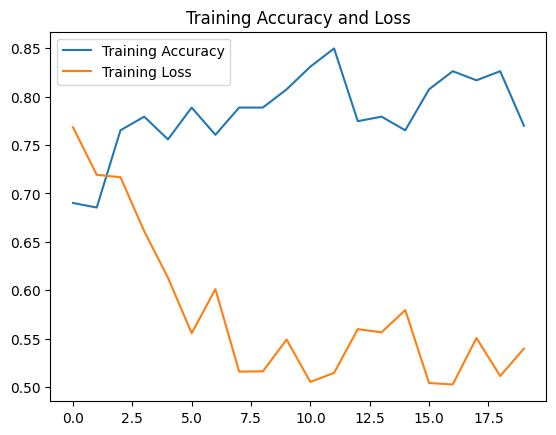

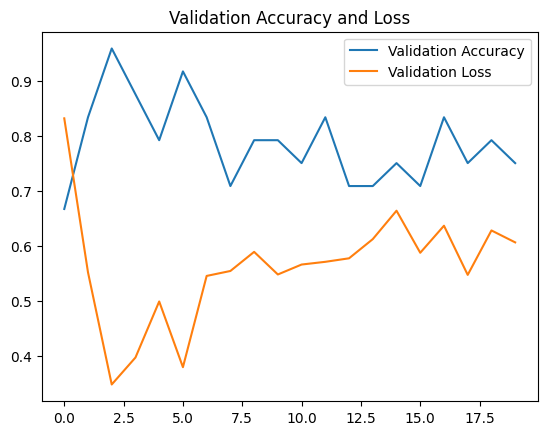

In [16]:
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

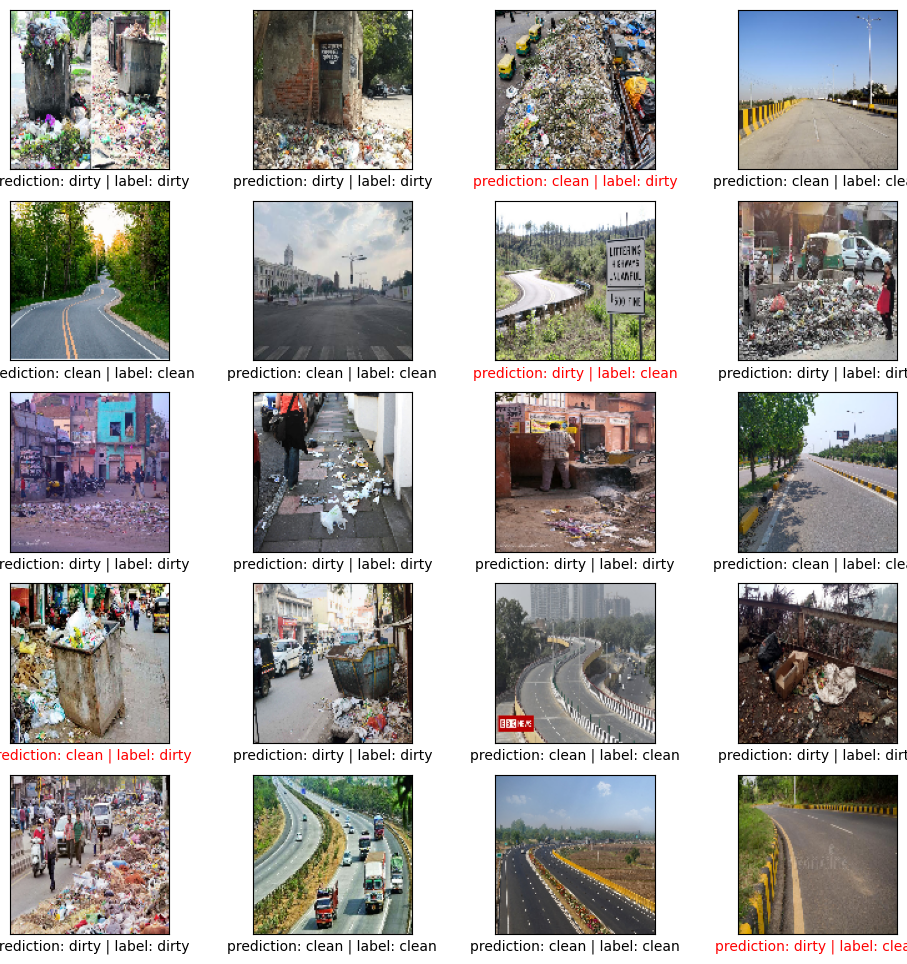

In [17]:
fig, axs = plt.subplots(5, 4, figsize=(12, 12))

i = 0
for x in range(5):
    for y in range(4):
        prediction = model.predict(X_val[i][None, ...], verbose=0)[0]

        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])

        if np.argmax(prediction) != np.argmax(y_val[i]):
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}', color='red')
        else:
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])

        i += 1
plt.show()

In [18]:
# Specify the image file path and desired image size
img_path = '/content/drive/MyDrive/Colab Notebooks/Assets/archive/test.jpeg'

# Read the image using OpenCV
img = cv2.imread(img_path)

# Resize the image to the desired size
img = cv2.resize(img, IMAGE_SIZE)

# Convert the image to a NumPy array
img_array = np.array(img)

# Print the shape of the resulting NumPy array
print(img_array.shape)

(128, 128, 3)


0


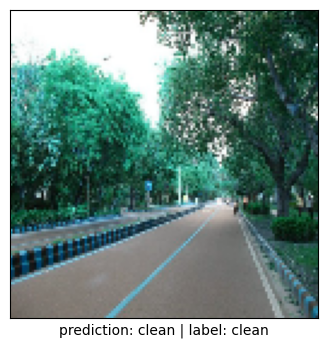

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))


prediction = model.predict(img_array[None, ...], verbose=0)[0]

axs.set_xticks([])
axs.set_yticks([])

print(np.argmax(prediction))

if np.argmax(prediction) != 0:
    axs.set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: clean', color='red')
else:
    axs.set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: clean')

axs.imshow(img)

# plt.show()